#Audio-based activity recognization
####***A machine learning pipeline to detect activities and events using sound***
#####The project involves data collection, data pre-processing/signal conditioning, feature extraction, using an existing ML implementation, and analysis of results for audio-based activity recognization.

#####The data used in the project are collected with Voice Recorder on an iPhone. 20 samples of five events (approximately 30 seconds each) including microwave, blender, fire alarm, vacuum cleaner, and music are collected to build the model from scratch. 20 samples of silence are also included. They are used to develop a logic that can be used in the future to filter out silent periods or segment actual events.

### Load pre-recorded data 
####***Pre-processing and feature extraction***


In [58]:
# Importing libraries
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from os.path import dirname, join as pjoin
from scipy.io import wavfile as wav
import scipy.io
import os
import librosa 
import librosa.display
import soundfile as sf
%matplotlib inline

Upload recorded audio data.zip into colab and unzip the file (it might take a few minutes to upload).

In [3]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

###Load data from wave file and store the faturized data and corresponding class label.  

####**Pre processing**
*   Trim and make each file the same length (30 seconds each)
* Normalize the amplitude of audio files so the value stays between 0 and 1 -- so we won't reply on loudness as a feature since it changes with distance
* Convert the raw time-domain signal into frequency-domain and normalize the amplitude using `librosa.stft`

####**Feature extraction**
Note: The whole 30 seconds recording is treated as a single "window" since dividing each recording into multiple windows didn't show better performance (potentially because most events I recorded are consistent the whole period).

*   ***Domain-specific features***

> * **Standard deviation of time-domain signal**: how loudness changes over time in a recording
> * **Standard deviation of frequency-domain signal**: how diverse the frequency spectrum is. This feature should be extremely useful for fire alarm and music since their frequencies varies a lot over the recording.
> * **Median of frequency-domain signal**: the median frequency should represent the main frequency level of white-noise classes (blender, vacuum, silence, and main microwave sound). For the rest, it should represent the overall frequency of the data to help us differentiate.
> * **Average zero-crossing rate of time-domain signal**: the rate at which a signal changes from positive to zero to negative or from negative to zero to positive. This feature aims the capture the change in voltage and should work well with music. \\
> * **Note**: for frequency-domain signal, since we want to observe the overall trend, the calculation is based on the weighted average frequency of each frame given by `librosa.feature.spectral_centroid`, where each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.



*    ***Spectrogram features***

> * **Mel-frequency cepstral coefficients (MFCCs)**: we bin the spectrogram data from the recordings and using each bin as a feature by using mfcc (convert the 2D array of samples given by stft in pre-processing into a smaller array)
>> * By calculating MFCC, we window the signal, apply the DFT, take the log of the magnitude, and then warp the frequencies on a Mel scale, followed by applying the inverse DCT. Basically, we have extracted features of each bin on a Mel scale.






In [56]:
def get_data(data_path):
  X, y = [], []
  file_names = [f.path for f in os.scandir(data_path) if (f.path != "/content/data/.DS_Store")]

  # Load each wave file and their label
  for file in file_names:
    print(f"Loading file {file}...")
    # Note: file name has format "/content/data/class_01.wav"
    class_label = (file.split("/")[-1]).split("_")[0]
    y.append(class_label)

    # ---------------------------Pre processing---------------------------------
    # Convert all the audio samples into the same length (30 seconds)
    time_domain_audio, sample_rate = librosa.load(file, duration=30)
    # Normalize the audio data so the value is only between 0 and 1
    time_domain_audio = librosa.util.normalize(time_domain_audio)
    # Convert time domain signal to frequency domain signal using librosa.stft
    freq_domain_audio = librosa.stft(time_domain_audio)

    # ------------------------------Featurize-----------------------------------
    features = []
    # Domain-specific features
    # Feature 1: standard deviation of time-domain signal
    feature1 = np.std(time_domain_audio)
    features.append(feature1)

    # Feature 2: standard deviation of frequency-domain signal
    # Note: frequency of each frame is the spectral centroid
    feature2 = np.std(librosa.feature.spectral_centroid(y=time_domain_audio))
    features.append(feature2)
    
    # Feature 3: Median of frequency-domain signal
    feature3 = np.median(librosa.feature.spectral_centroid(y=time_domain_audio))
    features.append(feature3)

    # Feature 4: Average zero-crossing rate of time-domain signal
    feature4 = np.mean(librosa.feature.zero_crossing_rate(time_domain_audio))
    features.append(feature4)

    # Feature 5 - 8: Extracted Mel-frequency cepstral coefficients (MFCCs)
    feature_mfcc = librosa.feature.mfcc(y=time_domain_audio)
    temp = []
    for i in range(4):
      mfcc_temp = 0
      for j in range(5):
        mfcc_temp += np.median(feature_mfcc[i*4+j])
      temp.append(mfcc_temp)
    features.extend(temp)
    
    X.append(features)
  
  print("DONE!")
  return X, y

X, y = get_data("/content/data")

Loading file /content/data/alarm_07.wav...
Loading file /content/data/silence_03.wav...
Loading file /content/data/vacuum_18.wav...
Loading file /content/data/alarm_05.wav...
Loading file /content/data/microwave_11.wav...
Loading file /content/data/blender_08.wav...
Loading file /content/data/silence_04.wav...
Loading file /content/data/blender_05.wav...
Loading file /content/data/music_05.wav...
Loading file /content/data/alarm_03.wav...
Loading file /content/data/blender_03.wav...
Loading file /content/data/alarm_20.wav...
Loading file /content/data/music_11.wav...
Loading file /content/data/blender_01.wav...
Loading file /content/data/microwave_18.wav...
Loading file /content/data/microwave_06.wav...
Loading file /content/data/music_15.wav...
Loading file /content/data/vacuum_19.wav...
Loading file /content/data/alarm_02.wav...
Loading file /content/data/music_20.wav...
Loading file /content/data/blender_10.wav...
Loading file /content/data/music_12.wav...
Loading file /content/data

###Train the model using `RandomForestClassifier` and analysis
**Observations:** The model seems to be really overfit. This might happen because for most of the data, we repeatly recorded the same infomation so there's not that much variety.
#####Analyze the pipeline's performance using 10-fold cross-validation.

In [166]:
# initialize score dictionary
scores = {}
scores["alarm"] = []
scores["blender"] = []
scores["microwave"] = []
scores["music"] = []
scores["vacuum"] = []
scores["silence"] = []

# Create 10 folds of data
cv = KFold(n_splits=10, random_state=42, shuffle=True)
clf = RandomForestClassifier(max_depth=3, random_state=0)

y_true = []
y_pred = []

In [167]:
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index)
    print("Test Index: ", test_index)
    X_train, X_test, y_train, y_test = np.array(X)[train_index], np.array(X)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    y_true.extend(np.ndarray.tolist(y_test))
    y_pred.extend(np.ndarray.tolist(predictions))
    for i in range(len(X_test)):
      spec_X_test, spec_y_test = X_test[i].reshape(1, -1), y_test[i].reshape(1, -1)
      scores[str(spec_y_test[0][0])].append(clf.score(spec_X_test, spec_y_test))

for key in scores:
  print(f"{key} mean accuracy:" + str(np.mean(scores[key])))

Train Index:  [  0   1   2   3   5   6   7   8   9  11  12  13  14  15  16  17  19  20
  21  22  23  24  25  27  28  29  30  31  32  33  34  35  36  37  38  39
  41  42  43  45  46  48  49  50  51  52  53  54  56  57  58  59  60  61
  63  65  66  67  68  69  70  71  72  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 108 109 110 111 112 113 114 115 116 117 118 119]
Test Index:  [  4  10  18  26  40  44  47  55  62  64  73 107]
Train Index:  [  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39
  40  41  42  43  44  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  66  67  68  69  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  90  92  93  94  95  96  97  98  99
 100 101 102 103 105 106 107 108 110 111 112 113 114 115 116 117 118 119]
Test Index:  [  0  11  31  36  

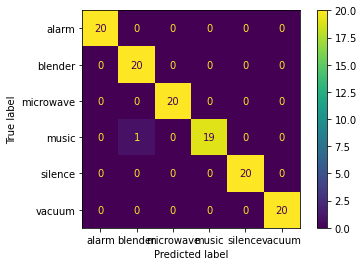

In [168]:
cm = confusion_matrix(y_true, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()